In [1]:
import datetime
from itertools import product

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from jetutils.anyspell import get_persistent_spell_times_from_som, mask_from_spells_pl
from jetutils.clustering import RAW_REALSPACE, Experiment
from jetutils.data import DataHandler, compute_anomalies_pl
from jetutils.definitions import (
    DATADIR,
    RESULTS,
    coarsen_da,
    compute,
    normalize,
    xarray_to_polars,
    get_region,
)
from jetutils.jet_finding import JetFindingExperiment
from jetutils.plots import Clusterplot, honeycomb_panel
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp = Experiment(dh)
centers_kmeans, labels_kmeans = exp.do_kmeans(7, 200)

In [4]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

In [5]:
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
da_ = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(exp.path.parent, da_, save_da=True)
exp_summer = Experiment(dh_summer)
net, centers, labels = exp_summer.som_cluster(4, 4, 200, sigma=1.5, sigmaN=1e-5, train_kwargs=dict(num_epochs=20), init="pca")

## KM results

In [ ]:
weekly = xarray_to_polars(labels_kmeans).group_by(pl.col("time").dt.week().alias("week")).agg(pl.col("labels").unique(), pl.col("labels").unique_counts().alias("count")).explode("labels", "count").sort("week", "labels")
unique_weeks = weekly["week"].unique().to_frame()
unique_labels = weekly["labels"].unique().to_frame()
index = unique_weeks.join(unique_labels, how="cross")
weekly = index.join(weekly, on=index.columns, how="left").fill_null(0)

(0.0, 1863.68)

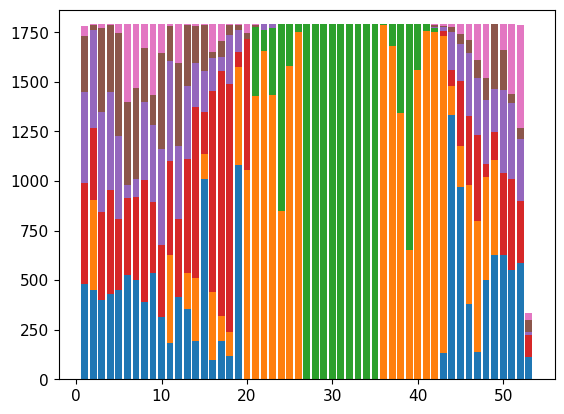

In [ ]:
bottom = np.zeros(len(unique_weeks))
x = unique_weeks["week"].to_numpy()
fig, ax = plt.subplots()
for lab in unique_labels["labels"].to_numpy():
    y = weekly.filter(pl.col("labels") == lab)["count"]
    plt.bar(x, y, bottom=bottom)
    bottom = bottom + y
ax.set_ylim(0, bottom.max() * 1.04)

In [ ]:
monthly = xarray_to_polars(labels_kmeans).group_by(pl.col("time").dt.month().alias("month")).agg(pl.col("labels").unique(), pl.col("labels").unique_counts().alias("count")).explode("labels", "count").sort("month", "labels")
unique_weeks = monthly["month"].unique().to_frame()
unique_labels = monthly["labels"].unique().to_frame()
index = unique_weeks.join(unique_labels, how="cross")
monthly = index.join(monthly, on=index.columns, how="left").fill_null(0)

(0.0, 8253.44)

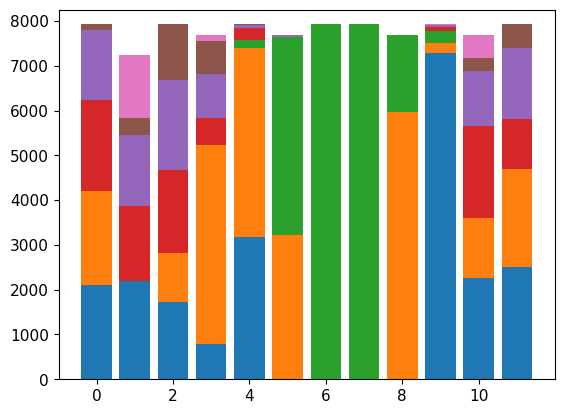

In [ ]:
bottom = np.zeros(12)
x = np.arange(12)
fig, ax = plt.subplots()
for lab in unique_labels["labels"].to_numpy():
    y = monthly.filter(pl.col("labels") == lab)["count"]
    plt.bar(x, y, bottom=bottom)
    bottom = bottom + y
ax.set_ylim(0, bottom.max() * 1.04)

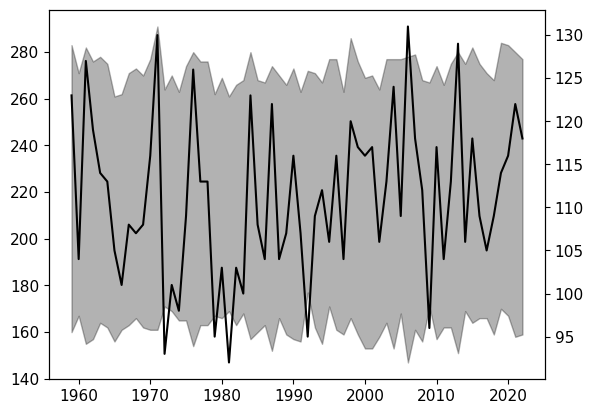

In [6]:
first_and_last = summer.to_frame().group_by(pl.col("summer").dt.year().alias("year")).agg(
    first_day=pl.col("summer").first().dt.ordinal_day(),
    last_day=pl.col("summer").last().dt.ordinal_day()
).sort("year")
fig, ax = plt.subplots()
# ax.plot(first_and_last["year"], first_and_last["first_day"], color="black")
# ax.plot(first_and_last["year"], first_and_last["last_day"], color="red")
ax.fill_between(first_and_last["year"], first_and_last["first_day"], first_and_last["last_day"], color="black", alpha=0.3)
ax.twinx().plot(first_and_last["year"], first_and_last["last_day"] - first_and_last["first_day"], color="black")

# sweep som sizes

In [ ]:
from sklearn.metrics import calinski_harabasz_score

nys = [2, 3, 4, 5, 6]
dys = [0, 2, 4]
# nxs = [6]
# dxs = [-2]
quant_errors = {}
topo_errors = {}
ch_indices = {}
projections = {}
X, da_weighted = exp_summer.prepare_for_clustering()
da_weighted = coarsen_da(da_weighted, 1.5)
X = da_weighted.data.reshape(exp_summer.data_handler.get_flat_shape()[0], -1)
X, meanX, stX = normalize(X)
X = compute(X, progress=True)
for ny, dy in tqdm(product(nys, dys), total=len(nys) * len(dys)):
    nx = ny + dy
    net, centers, labels = exp_summer.som_cluster(
        nx,
        ny,
        activation_distance="euclidean",
        return_type=RAW_REALSPACE,
        force=False,
        init="pca",
        sigma=1.5,
        sigmaN=1e-5,
        train_kwargs=dict(num_epochs=20),
    )
    quant_errors[(nx, ny)] = net.quantization_error(X)
    topo_errors[(nx, ny)] = net.topographic_error(X)
    ch_indices[(nx, ny)] = calinski_harabasz_score(X, labels)
    projections[(nx, ny)] = np.quantile((net.weights[labels] * X).sum(axis=1) / np.linalg.norm(net.weights, axis=1)[labels] / np.linalg.norm(X, axis=1), q=0.05)
df_losses = pd.DataFrame.from_records([projections, quant_errors, topo_errors, ch_indices]).transpose().rename({
    0: "projection", 1: "quantization_error", 2: "topographic_error", 3: "calinski_harabasz_score"
}, axis=1)
df_losses.to_parquet(f"{RESULTS}/two_step/era5_som_dyn_summer_sweep.parquet")
df_losses["size"] = [np.prod(a) for a in df_losses.index]
df_losses = df_losses.sort_values("size")

100%|██████████| 15/15 [09:00<00:00, 36.06s/it] 


<Axes: >

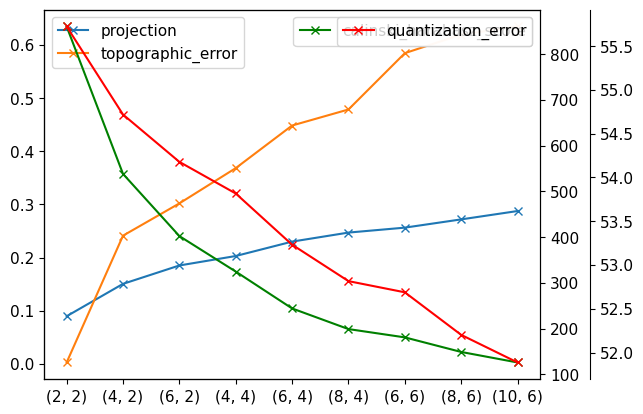

In [58]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.1))
df_losses[df_losses["size"] % 2 == 0].plot(y=["projection", "topographic_error"], marker="x", ax=ax)
df_losses[df_losses["size"] % 2 == 0].plot(y="calinski_harabasz_score", marker="x", ax=ax2, color="green")
df_losses[df_losses["size"] % 2 == 0].plot(y="quantization_error", marker="x", ax=ax3, color="red")

<Axes: >

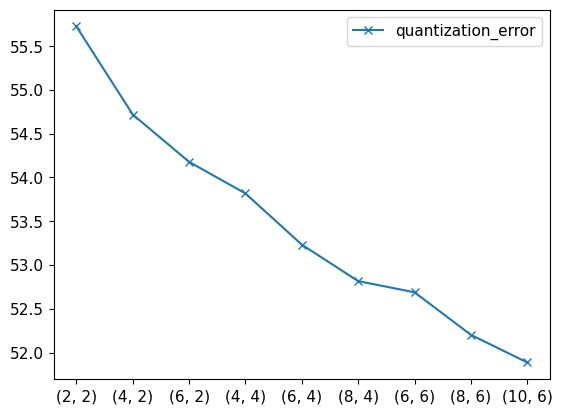

# SOM results

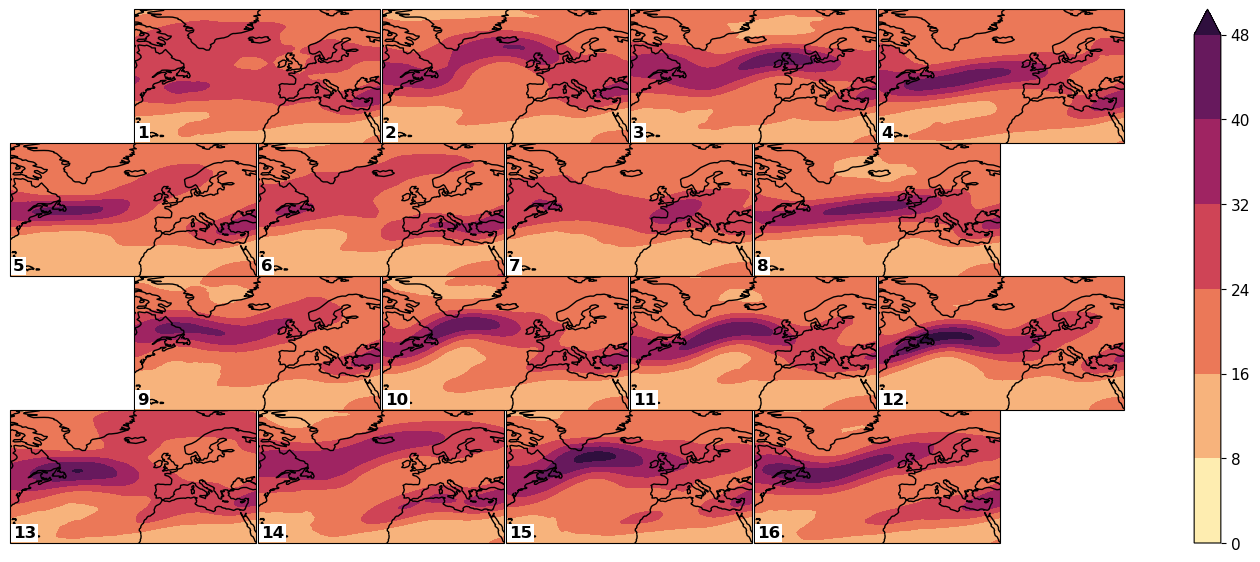

In [8]:
clu = Clusterplot(4, 4, get_region(dh.da), honeycomb=True, numbering=True)
_ = clu.add_contourf(centers, cmap=colormaps.matter, levels=7)

In [158]:
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.05)
spells = get_persistent_spell_times_from_som(labels, dists, sigma, 32, nt_before=12, nojune=False, daily=False)

(<Figure size 500x400 with 2 Axes>, <Axes: >)

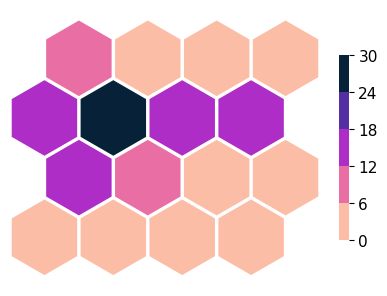

In [128]:
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
net.plot_on_map(spells_per_cluster["len"].to_numpy(), cmap=cmap, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

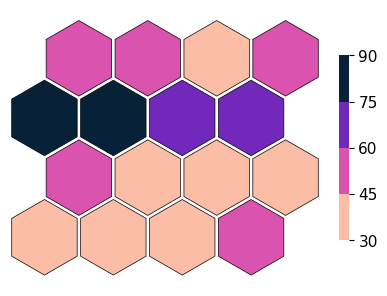

In [129]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").max())
max_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

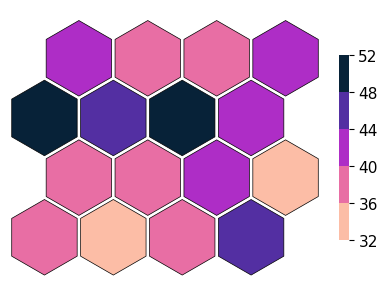

In [130]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
max_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.6})

In [134]:
exp_jets = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
props_as_df = exp_jets.props_as_df(True)
props_anoms = compute_anomalies_pl(props_as_df)
props_anoms_during_spells = mask_from_spells_pl(spells, props_anoms)
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
]

In [135]:
mean_props_during_spell = props_anoms_during_spells.filter(pl.col("relative_index") >= 0).group_by("value", "jet").agg(*[pl.col(col).mean() for col in data_vars], pl.col("len").mean()).sort("value", "jet")
quantiles = props_anoms.filter(
    pl.col("time").cast(pl.Datetime("ns")).is_in(labels.time.values)
).group_by("jet").agg(
    pl.concat_list(pl.col(col).quantile(.33), pl.col(col).quantile(.66)).alias(col) for col in data_vars
).with_columns(dummy=1).pivot(on="jet", index="dummy", values=data_vars).drop("dummy")
quantile_map = mean_props_during_spell.pivot(
    on="jet", index="value", values=data_vars
).join(quantiles, how="cross", suffix="_q").group_by("value", maintain_order=True).agg(
    pl.col(f"{col}_{jet}_q").explode().search_sorted(pl.col(f"{col}_{jet}")) for col in data_vars for jet in ["STJ", "EDJ"]
)


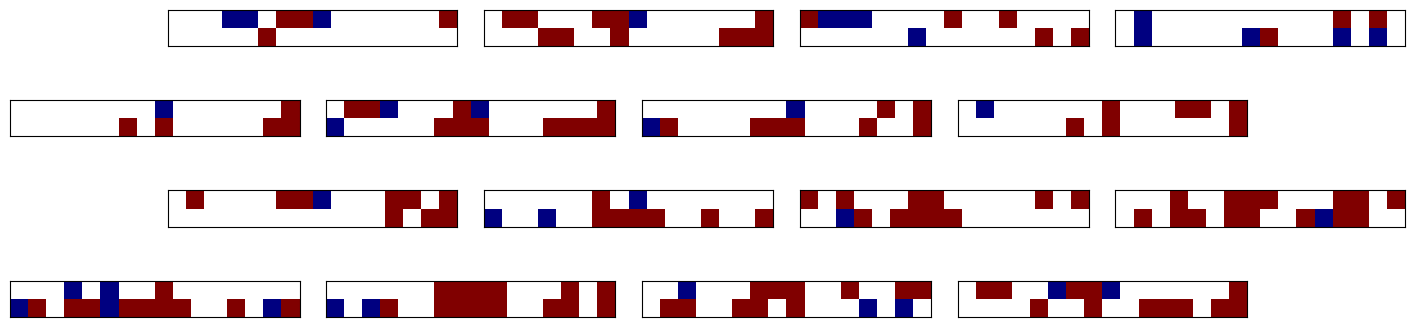

In [176]:
fig, axes = honeycomb_panel(net.y, net.x, subplot_kw={"aspect": "equal"}, hspace=.2, wspace=.2, ratio=.25)
axes = axes.ravel()
for i in range(net.n_nodes):
    ax = axes[i]
    to_plot = quantile_map[i].drop("value").to_numpy().reshape(16, 2).T
    ax.pcolormesh(to_plot, vmin=0, vmax=2, cmap=colormaps.BlWhRe)
    ax.set_xticks([])
    ax.set_yticks([])

# labels around onset